# RD53B Injection Pattern Generator

## Mask Generation Steps

In [1]:
from dataclasses import dataclass

@dataclass
class Step:
    dim: int
    size: int
    parallel: bool
    shifts: list
        
steps = [
    Step(0, 0, 0, [8, 1]),
    Step(1, 0, 1, []),
    Step(0, 8, 1, [])
]

## Size

In [2]:
total_size = [336, 432]

## Code

sizes [1, 48, 7]
sizes [1, 432]
[48] 48


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
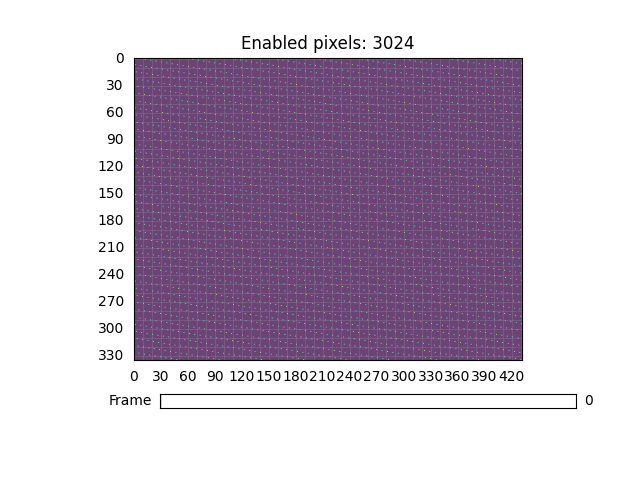

In [3]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from functools import reduce
from dataclasses import dataclass

sizes = [[1], [1]]
shifts = [[],[]]

for step in steps:
    sizes[step.dim].append(step.size)
    shifts[step.dim].append(step.shifts[0] if len(step.shifts) else 1)

for dim in range(2):
    zeroPos = next(i for i, x in enumerate(sizes[dim]) if x == 0)
    prev_size = np.prod(sizes[dim][:zeroPos])
    next_size = reduce(lambda a, b: - (-a // b), [total_size[dim], *sizes[dim][:zeroPos:-1]])
    lcm = np.lcm(prev_size, shifts[dim][zeroPos - 1])
    sizes[dim][zeroPos] = - (-next_size // lcm) * lcm / prev_size
    sizes[dim][:-1] = np.cumprod(sizes[dim][:-1], dtype=int)
    sizes[dim][-1] = -(-total_size[dim] // sizes[dim][-2]) * sizes[dim][-2]
    for i in range(len(sizes[dim]) - 1, 0, -1):
        sizes[dim][i] = sizes[dim][i] // sizes[dim][i - 1]
    print('sizes', sizes[dim])
    i = 1
    for step in steps:
        if step.dim == dim:
            step.size = sizes[dim][i]
            i += 1

seq_sizes = [step.size for step in steps if not step.parallel]
n_masks = np.prod(seq_sizes)
print(seq_sizes, n_masks)

def get_mask(id):
    shiftId = id
    mask = np.ones((1,1), dtype=np.uint8)

    currentShifts = []

    lastDim = 0
    for step in steps:
        size = step.size

        shape = mask.shape

        new_shape = list(shape)
        new_shape[step.dim] *= size

        new_mask = np.zeros(new_shape, dtype=np.uint8)

        for i in range(size) if step.parallel else [int(shiftId % size)]:
            shift = 0
            shift_count = i
            wrapAroundSize = shape[lastDim]
            for s in currentShifts:
                shift += shift_count * s
                shift_count = shift_count * s // wrapAroundSize
                wrapAroundSize = s
            shift %= shape[lastDim]

            # print(shift, i, shape, new_shape, i * shape[0], (i + 1) * shape[0])
        
            shifted =  np.roll(mask, shift, axis = lastDim)

            if step.dim == 0:
                new_mask[i * shape[0] : (i + 1) * shape[0], :] = shifted
            else:
                new_mask[:, i * shape[1] : (i + 1) * shape[1]] = shifted
                
        
        if not step.parallel:
            shiftId //= size

        lastDim = step.dim
        mask = new_mask
        # print(mask)
        currentShifts = step.shifts

    return mask[:total_size[0], :total_size[1]]

# mask_sum = np.zeros(total_size)
# for i in range(n_masks):
#     mask_sum += get_mask(i)
# print(np.count_nonzero(mask_sum != 1))

fig, ax = plt.subplots()

mask = get_mask(0)
l = plt.imshow(mask, vmin=0, vmax=1)
ax.set_title(f'Enabled pixels: {np.count_nonzero(mask)}')
# text = plt.figtext(1.0, 0.2, f'Enabled pixels: {np.count_nonzero(mask)}')

if n_masks > 1:
    plt.subplots_adjust(bottom=0.25)
    axidx = plt.axes([0.25, 0.15, 0.65, 0.03])
    slidx = Slider(axidx, 'Frame', 0, n_masks, valinit=0, valfmt='%d', valstep=1)
    
    def update(val):
        mask = get_mask(int(slidx.val))
        l.set_data(mask)
        ax.set_title(f'Enabled pixels: {np.count_nonzero(mask)}')
        fig.canvas.draw_idle()

    slidx.on_changed(update)

ax.set_xticks(np.arange(-.5, total_size[1], 30))
ax.set_yticks(np.arange(-.5, total_size[0], 30))
ax.set_xticklabels(np.arange(0, total_size[1], 30))
ax.set_yticklabels(np.arange(0, total_size[0], 30))
ax.set_xticks(np.arange(-.5, total_size[1], 1), minor=True)
ax.set_yticks(np.arange(-.5, total_size[0], 1), minor=True)
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.grid(which='both', alpha=.2)


plt.show()